## **1. American Sign Language**

 American Sign language is the primary language used by many deaf individuals in North America, In this notebook i will try to train a model to classify images of ASL letters, after loading, examining, and preprocessing the data, i will be able to train the model and test it.

 The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures and its each time more used by hard-of-hearing and hearing individuals because we have now realized about the importance of this language to communicate effectively with deaf people.

Because of the complexity of this problem we will find more effective to train the model using individual letters instead of sentences.

## **2. Visualize the training data**

Before visualizing the data we need to import a script with classical functions rewrited for this project by myself to load the data and use it to train the model you can find the script called *utils.py* properly commented in the same folder as this notebook.  Furthermore, we will import the necessary packages.

In [1]:
# Import packages
import math
import numpy as np
from random import randrange

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from utils import *

import os
import cv2

# Constants
image_size = 64
num_labels = 29

2022-12-27 22:30:45.830825: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-27 22:30:45.830922: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-27 22:30:54.062994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-27 22:30:54.064294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-27 22:30:54.064334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

Now we load the image using the functions from the script *utils.py*. We will also resize the images and use a function to split the data into training and testing sets with an accuracy of 70% and 30% respectively.

**It is importat to note that the function load_data() gathers the data from the folder assigned to the variable load_directory, so we could use the data from the asl_alphabet_train folder or the asl_alphabet_dev folder, in this case i don't have the hardware to train the data so i will use the
asl_alphabet_dev folder**

In [2]:
# Loading the dataset
X_train_origin, X_test_origin, Y_train_origin, Y_test_origin = load_data()
print ()
print ("X_train_origin shape: " + str(X_train_origin.shape))
print ("Y_train_origin shape: " + str(Y_train_origin.shape))
print ("X_test_origin shape: " + str(X_test_origin.shape))
print ("Y_test_origin shape: " + str(Y_test_origin.shape))


Loading... datasets/asl_alphabet_dev: F|W|N|O|B|E|G|P|J|A|H|D|U|V|del|nothing|space|L|Z|K|X|I|T|S|R|Y|C|M|Q|
X_train_origin shape: (3982, 64, 64, 3)
Y_train_origin shape: (1, 3982)
X_test_origin shape: (1707, 64, 64, 3)
Y_test_origin shape: (1, 1707)


## **3. Visualizing the data**

Now we are able to sketch a $n \times m$ figure with $n \times m$ images. In this case we will use a $5 \times 5$ figure with a sample of $25$ images.

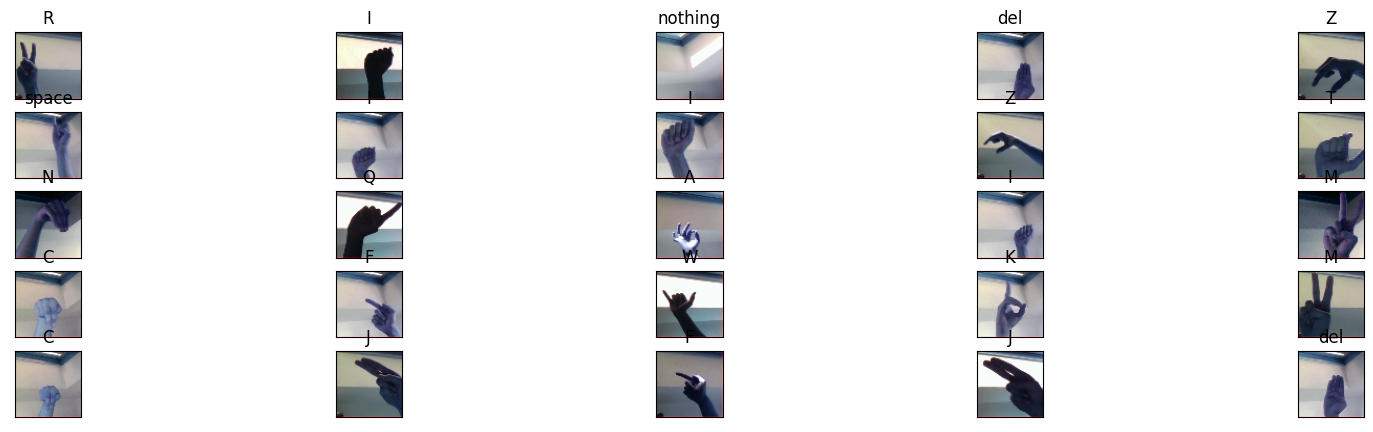

In [3]:
# Print the first several training images, along with the labels
labels = ['A','B','C','D','del','E','F','G','H','I','J','K','L','M','N','nothing','O','P','Q','R','S','space','T','U','V','W','X','Y','Z']
fig = plt.figure(figsize=(20,5))

count = 0
while count < 25:
    rannum = randrange(X_train_origin.shape[0])
    ax = fig.add_subplot(5, 5, count + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train_origin[rannum]))
    ax.set_title("{}".format(labels[Y_train_origin[0, rannum]]))
    count += 1
plt.show()

## **4. Handling with the images**

The next step is to flatten the images and convert them to hot matrices, this is done in the *utils.py* script as convert_to_one_hot() function.

In [4]:
# Flatten the training and test images
X_train = X_train_origin.reshape(X_train_origin.shape[0], -1).T
X_test = X_test_origin.reshape(X_test_origin.shape[0], -1).T

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_origin, 29)
Y_test = convert_to_one_hot(Y_test_origin, 29)

print ("Number of training examples = " + str(X_train.shape[1]))
print ("Number of test examples = " + str(X_test.shape[1]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples = 3982
Number of test examples = 1707
X_train shape: (12288, 3982)
Y_train shape: (29, 3982)
X_test shape: (12288, 1707)
Y_test shape: (29, 1707)


## **5. Define the model**

As suggested in the Datacamp Project Site, we will use a *Deep Neural Network* to train the data using *Tensorflow* and three hidden layers and as we knows that softmax layer generalizes the sigmoud outpot when we have more than two classes.
So by know we want to Create the placeholders for X and Y, initizialize the hyperparameters so we can train the model using Tensorflow and inspect the forward propagation and evaluate the cost of this computation.

The hyperparameters used here are the following:
> - learning_rate(alpha) = 0.0001
> - num_epochs = 1500
> - minibatch_size = 32
> - lambd = 0.001
Also we will work with an amount of $5000$ images to avoid the bias to a point.

## **6. Compiling the model**
Firstly, we will create the placeholders. 

In [5]:
#Creating the placeholders
def create_placeholders(n_x, n_y):
    tf.compat.v1.disable_eager_execution()
    X = tf.compat.v1.placeholder(tf.float32, name="X", shape =[n_x, None])
    Y = tf.compat.v1.placeholder(tf.float32, name="Y", shape =[n_y, None])
    return X, Y

Now we set the parameters of the model.

In [6]:
#Setting the hyperparameters
def initialize_parameters():
    tf.random.set_seed(5)
        
    W1 = tf.compat.v1.get_variable("W1", [64,12288], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed = 1))
    b1 = tf.compat.v1.get_variable("b1", [64,1], initializer = tf.zeros_initializer())
    W2 = tf.compat.v1.get_variable("W2", [52,64], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed = 1))
    b2 = tf.compat.v1.get_variable("b2", [52,1], initializer = tf.zeros_initializer())
    W3 = tf.compat.v1.get_variable("W3", [29,52], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed = 1))
    b3 = tf.compat.v1.get_variable("b3", [29,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

Now we also want to create the forward_propagation function to implement it to the Tensorflow model.

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

Now we define the compute_cost function.

In [8]:
def compute_cost(A3, Y):
    """
    Computes the cost
    """
    logits = tf.transpose(A3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost

## **7. Training the model, testing and mistakes**

Now that we have defined all the necessary things to implement our DNN model we follow as usual as we first build the model.

In [9]:
def model(X_train, Y_train, X_test, Y_test, regularization, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True, lambd = 0.001):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.random.set_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    # Initialize parameters
    parameters = initialize_parameters()
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    # Cost function: Add cost function after regularizating to tensorflow graph
    cross_entropy_cost = compute_cost(Z3, Y )
    
    # Original cost function
    if regularization == False:
        cost = cross_entropy_cost
    # Cost function using L2 Regularization
    if regularization == True:      
        weights = tf.Variable(tf.random.truncated_normal([X_train.shape[0], num_labels]))
        regularizer = tf.nn.l2_loss(weights)
        cost = tf.reduce_mean(cross_entropy_cost + lambd * regularizer)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate := learning_rate).minimize(cost, var_list = parameters)
    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per five)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Now we finally set up our last parameters for this model.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 13.044384
Cost after epoch 100: 4.566943
Cost after epoch 200: 2.794419
Cost after epoch 300: 1.854914
Cost after epoch 400: 1.233203
Cost after epoch 500: 0.848641
Cost after epoch 600: 0.609014
Cost after epoch 700: 0.404597
Cost after epoch 800: 0.245731
Cost after epoch 900: 0.279059
Cost after epoch 1000: 0.099072
Cost after epoch 1100: 0.070847
Cost after epoch 1200: 0.045805
Cost after epoch 1300: 0.033652
Cost aft

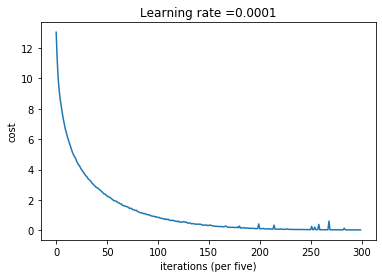

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.92852956


In [11]:
parameters = model(X_train, Y_train, X_test, Y_test, regularization = False)


Now add regularization to the model but in any case the model is alredy acceptable since regularization is not useful to ereduce overfitting in this case.

2022-12-27 19:34:30.042431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Cost after epoch 0: 551.413586
Cost after epoch 100: 541.093645
Cost after epoch 200: 539.280610
Cost after epoch 300: 538.619093
Cost after epoch 400: 538.392508
Cost after epoch 500: 538.308430
Cost after epoch 600: 538.284472
Cost after epoch 700: 538.279332
Cost after epoch 800: 538.270886
Cost after epoch 900: 538.268406
Cost after epoch 1000: 538.267028
Cost after epoch 1100: 538.266172
Cost after epoch 1200: 538.266933
Cost after epoch 1300: 538.265850
Cost after epoch 1400: 538.264706


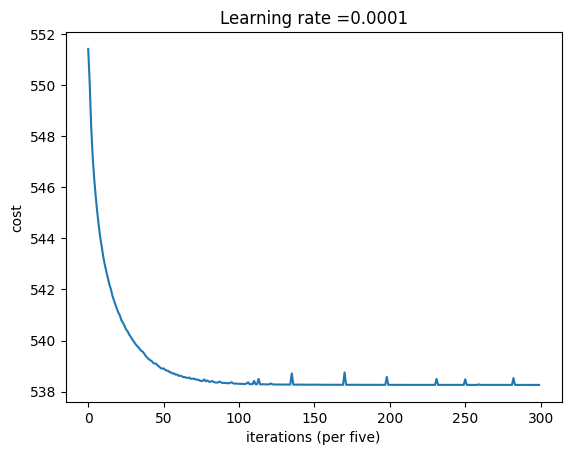

Parameters have been trained!


2022-12-27 20:55:04.068125: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 195723264 exceeds 10% of free system memory.


Train Accuracy: 1.0


2022-12-27 20:55:07.421737: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 83902464 exceeds 10% of free system memory.


Test Accuracy: 0.9619215


In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test, regularization = True)

So finally we have built or model and check the accuracy of the model and clearly the test accuracy has improved when we added the regularization.

#### *This was collected and solved by jdpalmad. the dataset was taken from Kaggle.*